# Gold Recovery Model for Zyfra

In this project we need to develop a prototype of a machine learning model to predict gold recovery from the ore. The model should enable process optimization and allow for the elimination of unprofitable parameters.
The project will proceed in 3 stages:
1. Data preparation
2. Data analysis
3. Model development and training

The following is a brief overview of the purification process and associated quantities for reference:

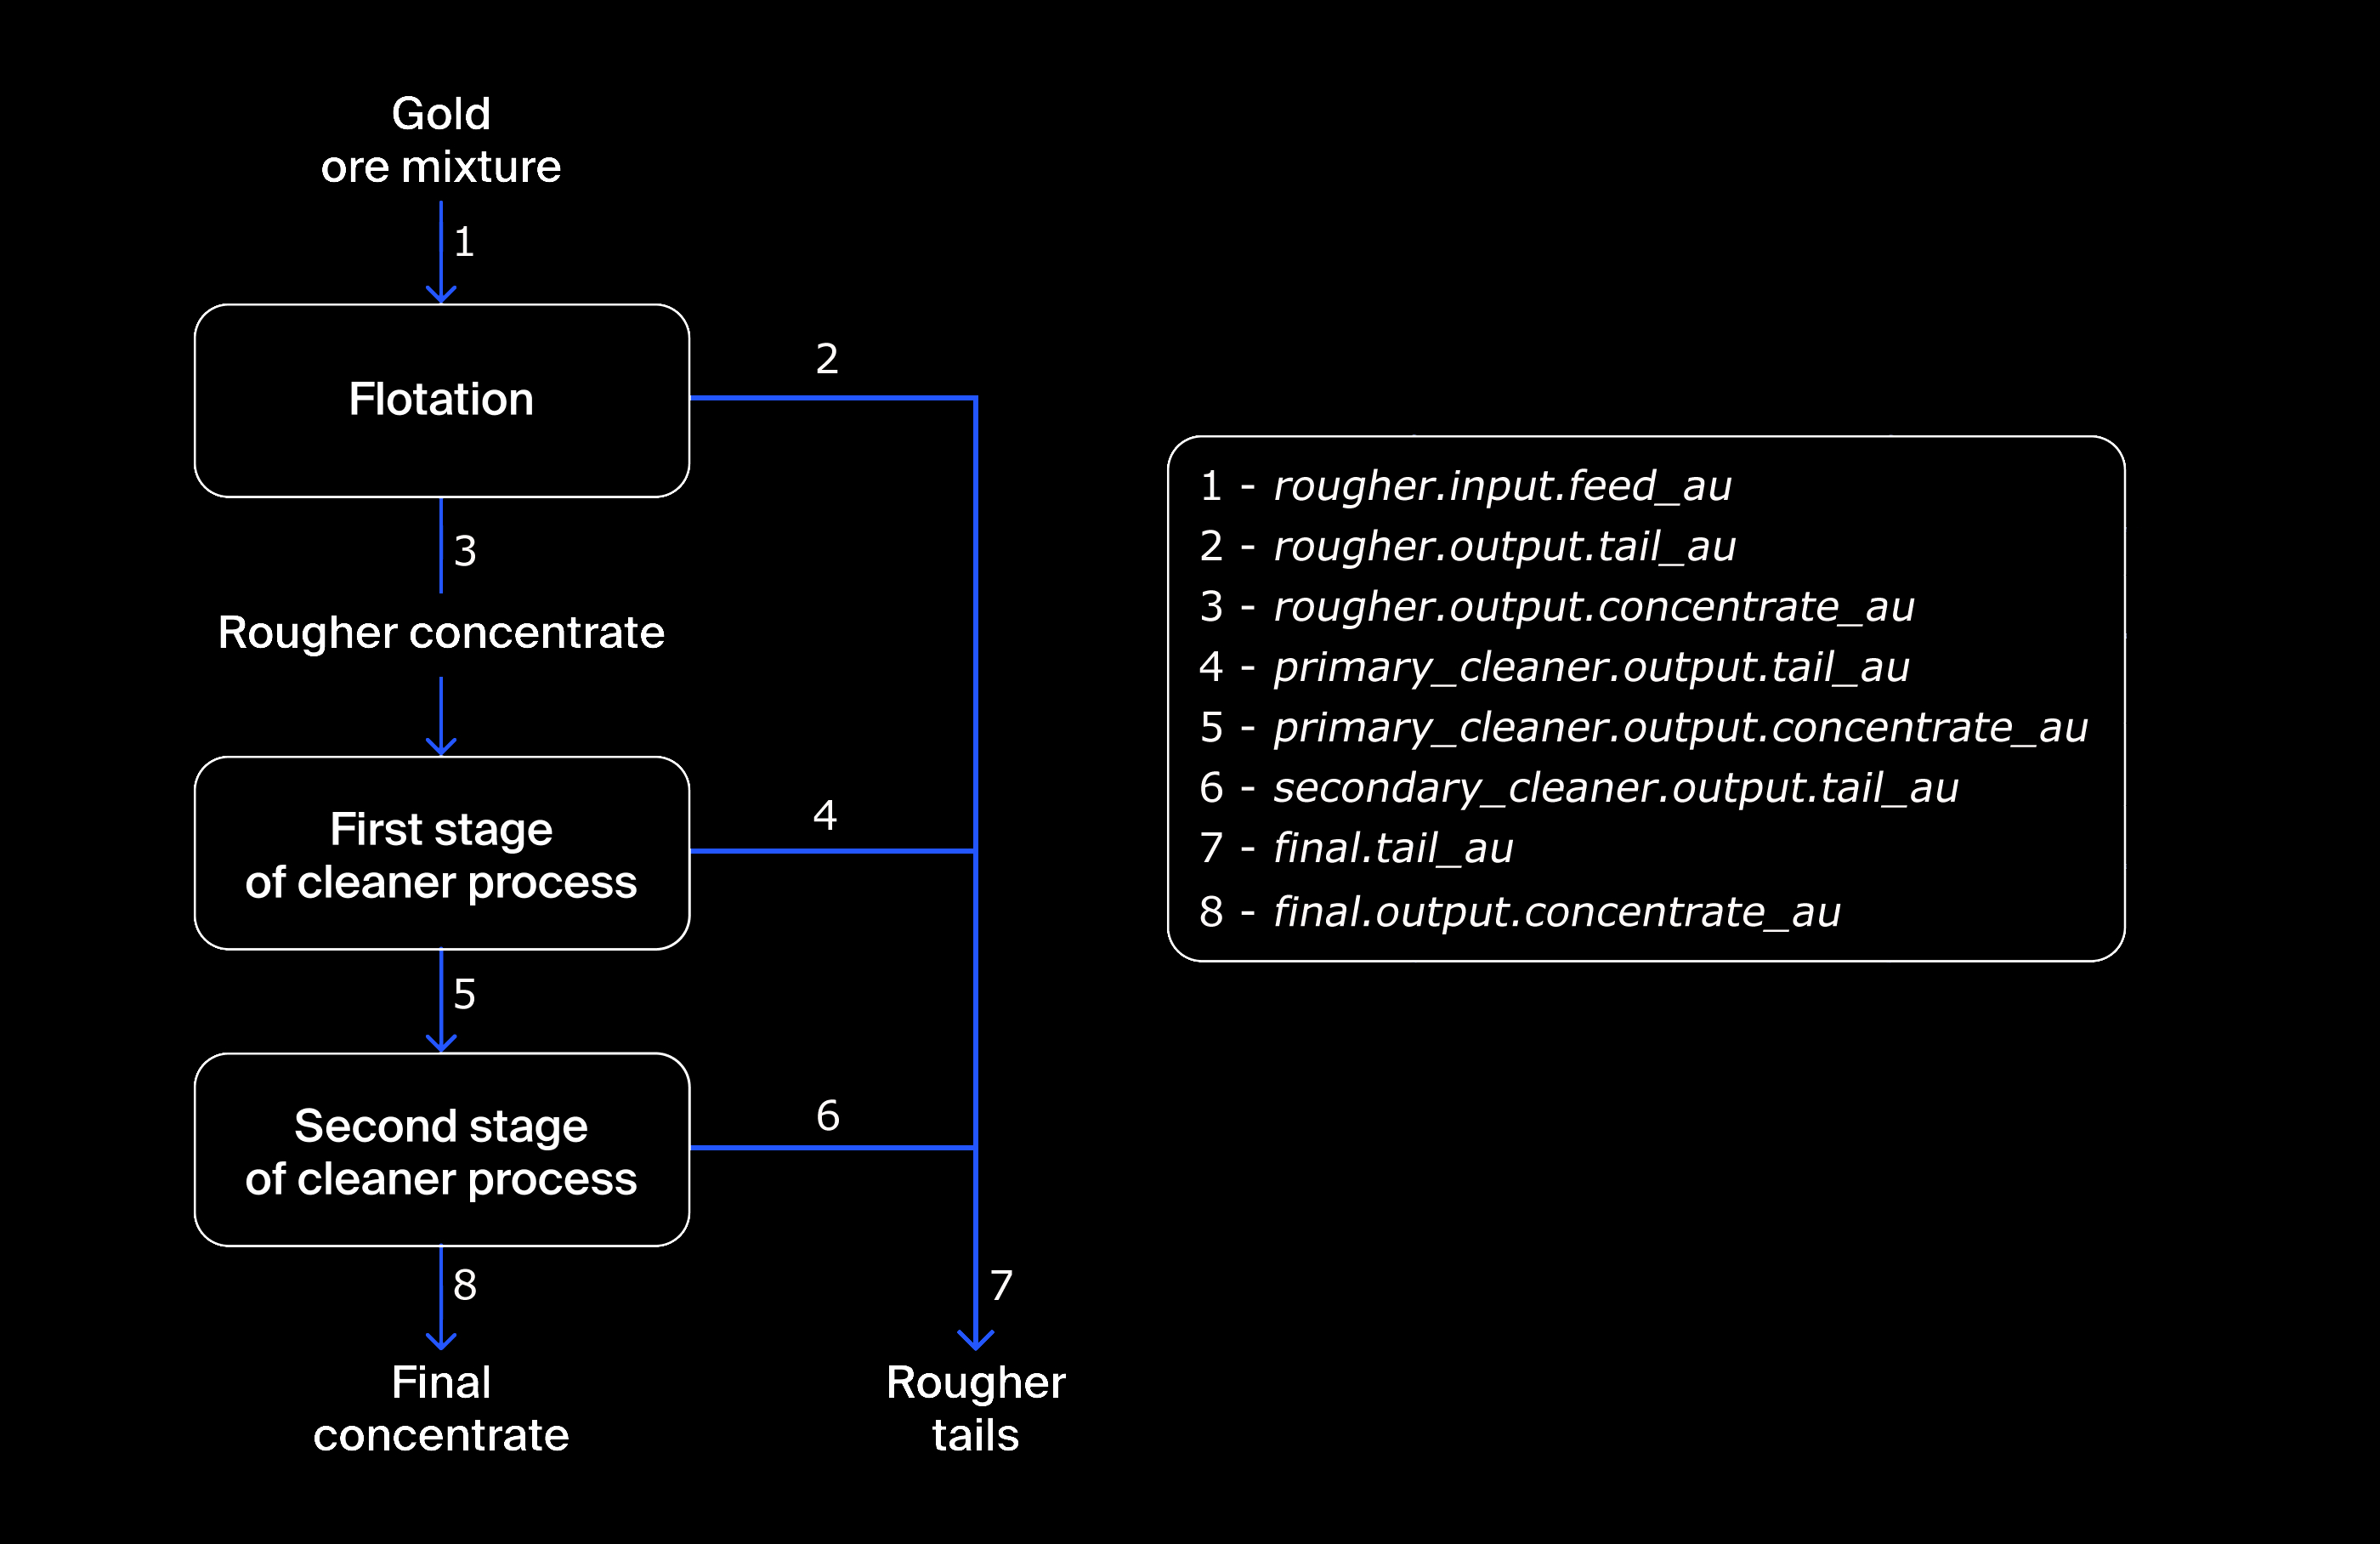

Recovery is calculated as:

Recovery = C*(F-T)/F*(C-T)*100

where
    C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
    F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
    T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

And the model needs to be optimized to minimize sMAPE (symmetric Mean Absolute Percentage Error)

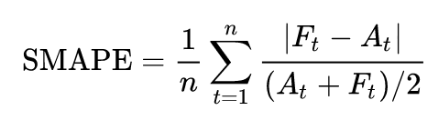

where _At stands for the actual value, while _Ft is the forecast and n is the number of observations over which the sum is calculated.

We need to predict two values:

    1. rougher concentrate recovery rougher.output.recovery
    2. final concentrate recovery final.output.recovery

Final sMAPE = 25% * sMAPE(rougher) + 75% * sMAPE(final)


## Data preparation:

In [21]:
#importing required libraries
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import randint
import seaborn as sns
from matplotlib import pyplot as plt
import plotly as py
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [22]:
#loading the data and examining it
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')
gold_recovery_train.info()
display(gold_recovery_train.head())
gold_recovery_test.info()
display(gold_recovery_test.head())
gold_recovery_full.info()
display(gold_recovery_full.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


The final and training sets have 87 columns and they contain the output info for each stage. This is missing in the test set.
At this stage, we know that the model needs to predict two outputs, the rougher output recovery and the final output recovery. It may make sense to remove all the output values while training the model to avoid the values from leaking and contaminating the predictions. 
The data types are correct for the most part except for date which we could convert to pandas date time object type, though this is unlikely to be relevant for model developement.

### Missing values and duplicates

In [23]:
#detect the percentage of missing values in each data set
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display((gold_recovery_train.isna().sum()/gold_recovery_train.shape[0])*100)
print()
display((gold_recovery_test.isna().sum()/gold_recovery_test.shape[0])*100)
print()
display((gold_recovery_full.isna().sum()/gold_recovery_full.shape[0])*100)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

date                                                   0.000000
final.output.concentrate_ag                            0.427046
final.output.concentrate_pb                            0.427046
final.output.concentrate_sol                           2.194543
final.output.concentrate_au                            0.421115
final.output.recovery                                  9.021352
final.output.tail_ag                                   0.391459
final.output.tail_pb                                   1.085409
final.output.tail_sol                                  0.860024
final.output.tail_au                                   0.391459
primary_cleaner.input.sulfate                          7.752076
primary_cleaner.input.depressant                       7.485172
primary_cleaner.input.feed_size                        0.000000
primary_cleaner.input.xanthate                         5.842230
primary_cleaner.output.concentrate_ag                  0.486358
primary_cleaner.output.concentrate_pb   

date                                          0.000000
primary_cleaner.input.sulfate                 5.157104
primary_cleaner.input.depressant              4.849727
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                2.834699
primary_cleaner.state.floatbank8_a_air        0.273224
primary_cleaner.state.floatbank8_a_level      0.273224
primary_cleaner.state.floatbank8_b_air        0.273224
primary_cleaner.state.floatbank8_b_level      0.273224
primary_cleaner.state.floatbank8_c_air        0.273224
primary_cleaner.state.floatbank8_c_level      0.273224
primary_cleaner.state.floatbank8_d_air        0.273224
primary_cleaner.state.floatbank8_d_level      0.273224
rougher.input.feed_ag                         0.273224
rougher.input.feed_pb                         0.273224
rougher.input.feed_rate                       0.683060
rougher.input.feed_size                       0.375683
rougher.input.feed_sol                        1.144126
rougher.in

date                                                   0.000000
final.output.concentrate_ag                            0.391794
final.output.concentrate_pb                            0.382990
final.output.concentrate_sol                           1.694841
final.output.concentrate_au                            0.378588
final.output.recovery                                  8.641486
final.output.tail_ag                                   0.365381
final.output.tail_pb                                   0.880437
final.output.tail_sol                                  1.192992
final.output.tail_au                                   0.356577
primary_cleaner.input.sulfate                          7.083113
primary_cleaner.input.depressant                       6.805776
primary_cleaner.input.feed_size                        0.000000
primary_cleaner.input.xanthate                         5.066913
primary_cleaner.output.concentrate_ag                  0.431414
primary_cleaner.output.concentrate_pb   

We see that a lot of rougher output values are missing both in the full dataset as well as in the training set (more than 10% of the values in each column).
Let us see if there are a lot of duplications.

In [24]:
print(gold_recovery_train.duplicated().sum())
print(gold_recovery_test.duplicated().sum())
print(gold_recovery_full.duplicated().sum())

0
0
0


In [25]:
#convert data types
gold_recovery_train['date'] = pd.to_datetime(gold_recovery_train['date'], format='%Y-%m-%d %H:%M:%S')
gold_recovery_test['date'] = pd.to_datetime(gold_recovery_test['date'], format='%Y-%m-%d %H:%M:%S')
gold_recovery_full['date'] = pd.to_datetime(gold_recovery_full['date'], format='%Y-%m-%d %H:%M:%S')

In [26]:
#we want to fill in missing values in the training dataset using corresponding values from the full data set where possible
#first we merge on date to see where samples would be the same
merged = gold_recovery_train.merge(gold_recovery_full, on='date', suffixes=('', '_full'))
# Fill missing values from the full set
filled_columns = []
for column in gold_recovery_train.columns:
    if column != 'date':
        before_na = merged[column].isna().sum()
        merged[column] = merged[column].fillna(merged[f"{column}_full"])
        after_na = merged[column].isna().sum()
        if after_na < before_na:
                filled_columns.append(column)
# Drop the suffix _full columns to get the filled training set
gold_recovery_train = merged[gold_recovery_train.columns]
print("Filled from full dataset:", filled_columns)

Filled from full dataset: []


The values missing in the training set are also missing in the full set. So it cannot be used to fill in missing values.

In [27]:
gold_recovery_train = gold_recovery_train.copy()
#is the recovery calculated correctly, let us make two new columns rougher_reco_calc and final_reco_calc
#Recovery = C*(F-T)/F*(C-T)*100
cr = gold_recovery_train['rougher.output.concentrate_au']
fr = gold_recovery_train['rougher.input.feed_au']
tr = gold_recovery_train['rougher.output.tail_au']
cf = gold_recovery_train['final.output.concentrate_au']
ff = gold_recovery_train['rougher.output.concentrate_au']
tf =  gold_recovery_train['final.output.tail_au']
ff2 = gold_recovery_train['rougher.input.feed_au']
gold_recovery_train['rougher_reco_calc'] = ((cr*(fr-tr))/(fr*(cr-tr)))*100
gold_recovery_train['final_reco_calc'] = ((cf*(ff-tf))/(ff*(cf-tf)))*100
gold_recovery_train['final_reco_calc_2'] = ((cf*(ff2-tf))/(ff2*(cf-tf)))*100
gold_recovery_train.loc[:,['final.output.recovery','final_reco_calc','final_reco_calc_2','rougher.output.recovery','rougher_reco_calc']].sample(50)

,final.output.recovery,final_reco_calc,final_reco_calc_2,rougher.output.recovery,rougher_reco_calc
7426,66.670110,90.886582,66.670110,85.235753,85.235753
8510,68.957112,92.509400,68.957112,82.243442,82.243442
6306,69.069624,91.680524,69.069624,89.165759,89.165759
3640,70.581500,93.450855,70.581500,77.073198,77.073198
1951,NaN,NaN,NaN,NaN,NaN
8290,66.992104,92.297956,66.992104,83.098215,83.098215
6362,70.795983,91.959496,70.795983,91.291742,91.291742
16365,68.600745,90.481975,68.600745,86.231038,86.231038
7430,65.305814,90.285532,65.305814,85.076965,85.076965
3703,75.767001,93.525728,75.767001,82.681520,82.681520


There is very minimal difference between the recovery calculated for rougher stage but there is a lot of difference for the final recovery calculations at first glance if we use the rougher output for the feed value as the formula recommends. It is likely that the calculations for final recovery were made taking the value of the feed even before rougher flotation as the feed value. Let us know calculate the MAE for these calculations versus the values in the table.

In [28]:
#calculate mean absolute error betweeen calculated and predicted values
mae_data = gold_recovery_train[
    np.isfinite(gold_recovery_train['rougher_reco_calc']) &
    np.isfinite(gold_recovery_train['rougher.output.recovery']) &
    np.isfinite(gold_recovery_train['final_reco_calc']) &
    np.isfinite(gold_recovery_train['final.output.recovery']) &
    np.isfinite(gold_recovery_train['final_reco_calc_2'])
]
mae_r = mean_absolute_error(mae_data['rougher_reco_calc'], mae_data['rougher.output.recovery'])
mae_f = mean_absolute_error(mae_data['final_reco_calc'], mae_data['final.output.recovery'])
mae_f2 = mean_absolute_error(mae_data['final_reco_calc_2'], mae_data['final.output.recovery'])
print(f"The mean absolute error between calculated and recorded recovery from the rougher is {mae_r:0.2f}")
print(f"The mean absolute error between calculated (from the rougher output) and final recorded recovery  is {mae_f:0.2f}")
print(f"The mean absolute error between calculated (from the ore) and recorded final recovery is {mae_f2:0.2f}")

The mean absolute error between calculated and recorded recovery from the rougher is 0.00
The mean absolute error between calculated (from the rougher output) and final recorded recovery  is 24.53
The mean absolute error between calculated (from the ore) and recorded final recovery is 0.00


It is clear from the calculation that for the rougher flotation the recover has been calculated correctly. The mean absolute error in this case is 0.
However, when it comes to the final recovery, it is clear that it has been calculated using the ore as the starting point and not the rougher output as indicated in the formula. This is seen clearly when you consider that the MAE for the former is 0 and 24.53 for the latter.
Even though the given formula suggests using the rougher output for the feed value, I believe that using the ore as the starting point makes more sense since this calculation is for final (or overall) recovery and that would mean how much we managed to concentrate gold from the starting point (which is ore).
They have mentioned that the full set has the most complete data and we could attempt to plug in the values missing in the training set with matching values from the full set.

In [29]:
#can we use date for comparing rows?
print(gold_recovery_full['date'].duplicated().sum())
print(gold_recovery_train['date'].duplicated().sum())

0
0


## The way to handle missing values
There are multiple columns in the 87 columns with missing values and some of them are up to 15 % of the entire data. Since it is spread across the data, it does not make sense to impute the values since at this point we do not know the extent to which they influence each other.
I would consider dropping the values. 15% is still tolerable and we are more likely to get better predictions by discarding than filling with mean and median which may not be accurate for such complex processes.

In [30]:
#dropping missing values in the training set
#removing columns that could cause leakage by removing columns not present in the test set
#making a new output_dataframe with only relevant recoveries
common_cols = gold_recovery_train.columns.intersection(gold_recovery_test.columns)
gold_recovery_features = gold_recovery_train[common_cols].copy()
gold_recovery_features.dropna(inplace=True)
gold_recovery_features.info()
gold_recovery_target = gold_recovery_train[['rougher.output.recovery','final.output.recovery']].copy()
gold_recovery_target.dropna(inplace=True)
gold_recovery_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13522 entries, 0 to 16859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        13522 non-null  datetime64[ns]
 1   primary_cleaner.input.sulfate               13522 non-null  float64       
 2   primary_cleaner.input.depressant            13522 non-null  float64       
 3   primary_cleaner.input.feed_size             13522 non-null  float64       
 4   primary_cleaner.input.xanthate              13522 non-null  float64       
 5   primary_cleaner.state.floatbank8_a_air      13522 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_level    13522 non-null  float64       
 7   primary_cleaner.state.floatbank8_b_air      13522 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_level    13522 non-null  float64       
 9   primar

### Summary
We have created dataframes for the three data files and examined them for duplicates and missing values. We converted the date column to datetime for easier processing but besides this, the data types were correct. 

There is no duplication of rows, however, a lot of data was missing in the training and full datasets, up to 15% in some columns. The data missing in the training set was also missing in the full set, so the full set could not be used to fill in missing data in the training set. Since imputing the missing values could lead to leakage if the columns were interdependent, the decision was made to drop the missing values even tough 15% or so of values are missing in some columns. After dropping the missing values, we have a training set of 11000 rows but with no missing values which should be enough for training the model since the data is complete in all columns.

The features missing in the test set are output values for the rougher and final stage and since rougher recovery and final recovery are the values that we wish to predict using the model, it makes sense that these features are missing in the test set as well as other output values which could lead to leakage and contaminate the model. When we train the mdodel as well, it is best to drop these columns. They are all float types.

We caluclated the MAE fro rougher and final recovery after calculating the recovery to ensure that the calculations were done correctly. We would like to note that finalr ecovery was caluclated using the ore as the starting point and not the rougher output as was implied in the formula. Since final recovery is for recovery from the ore, we decided it was best to leave this caluclation as is and not revert to rougher output based calculation.

Data processing was done on the training set before training the model by dropping null values and removing columns that could cause leakage.

## Exploratary Data Analysis
### How metal concentrations change through the purification stages:

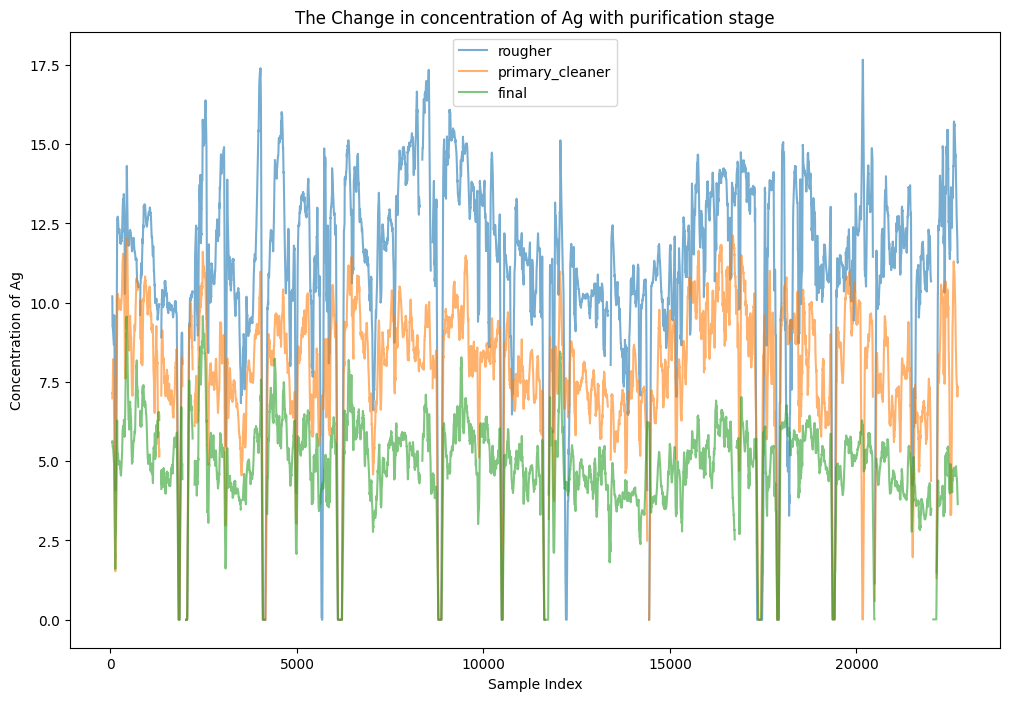

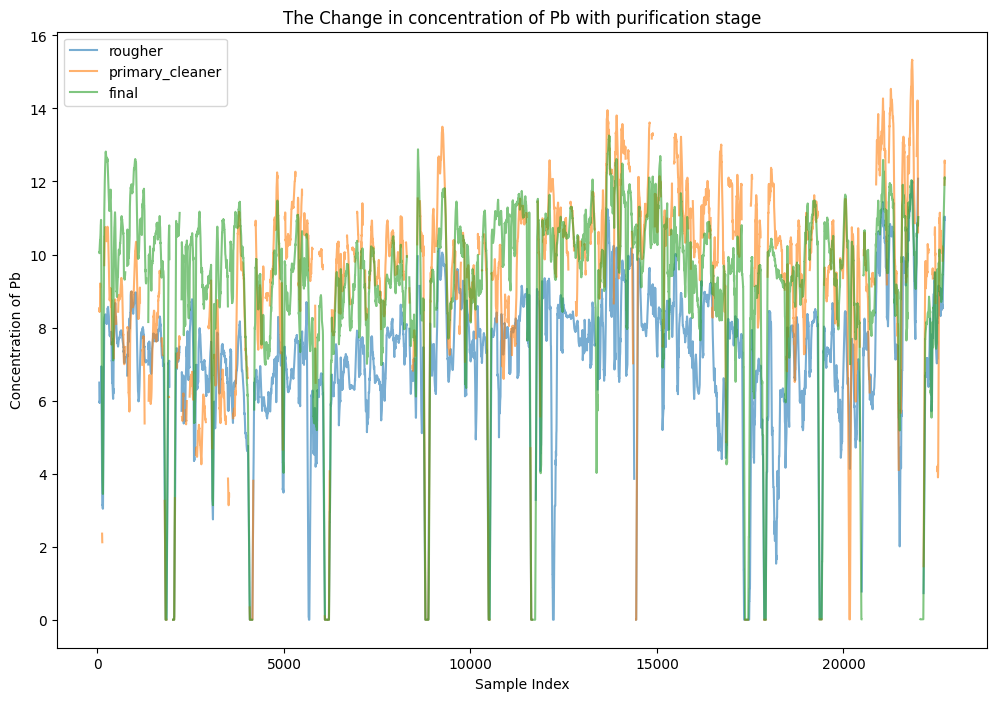

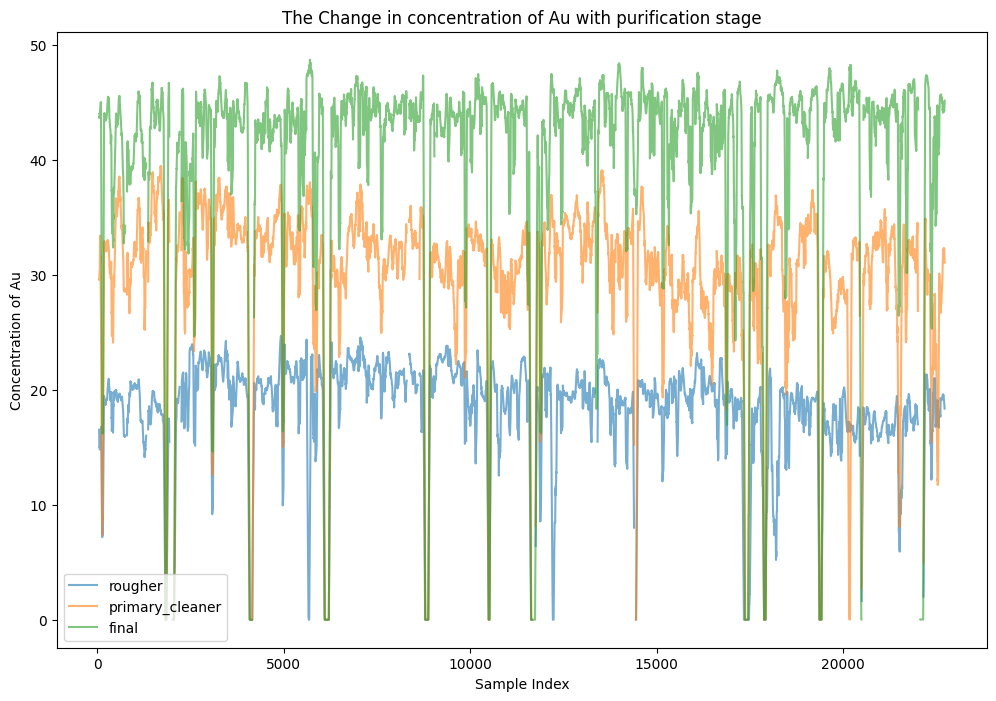

In [31]:
#output metal columns have names like final.output.concentrate_ag, i.e., stage.output.concentrate_metalname
#we need to iterate through each stage and each metal
#we need a rolling window average since there are so many values very close together that could leed to a lot of noise, we need to smoothen the data to see trends
window_size = 50
metals = ['Ag','Pb','Au']
stages = ['rougher','primary_cleaner','final']
for metal in metals:
    plt.figure(figsize=(12, 8))
    for stage in stages:
        column_name = f'{stage}.output.concentrate_{metal.lower()}'
        if column_name in gold_recovery_full.columns:
            plot_data = gold_recovery_full[column_name].rolling(window=window_size).mean()
            plt.plot(plot_data, label=stage, alpha=0.6)
        else:
            print(f"{column_name} is not present in the final set")
    plt.title(f"The Change in concentration of {metal} with purification stage")
    plt.xlabel("Sample Index")
    plt.ylabel(f"Concentration of {metal}")
    plt.legend()
    plt.show()

We see that Gold is enriched at each stage while the concentration of the impurities is reduced. We see significant improvement with Silver concentrations being reduced. However, lead seems to be a hard impurity to get rid of since the concentration stays largely constant through every stage of purification.

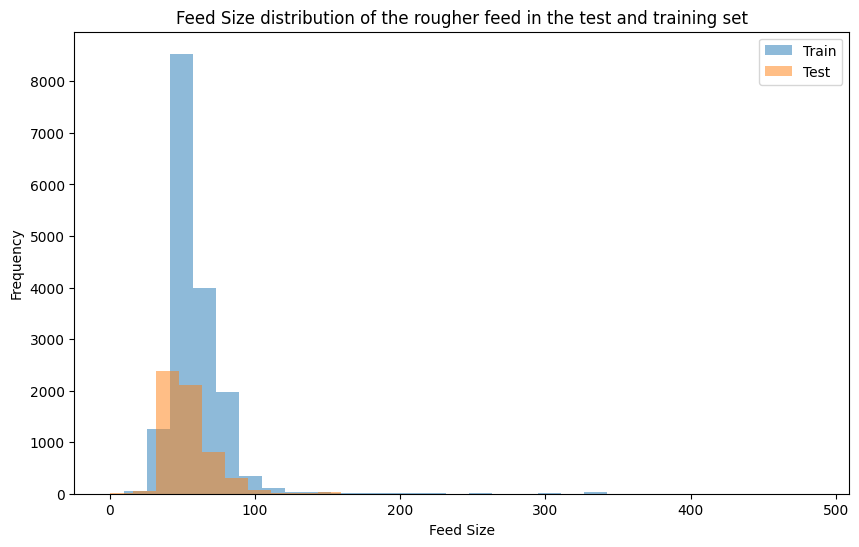

In [32]:
#plotting size distribution of rougher input feed size
plt.figure(figsize=(10,6))
plt.hist(gold_recovery_train['rougher.input.feed_size'],bins=30,alpha=0.5,label='Train')
plt.hist(gold_recovery_test['rougher.input.feed_size'],bins=30,alpha=0.5,label='Test')
plt.title("Feed Size distribution of the rougher feed in the test and training set")
plt.xlabel("Feed Size")
plt.ylabel("Frequency")
plt.legend()
plt.show()

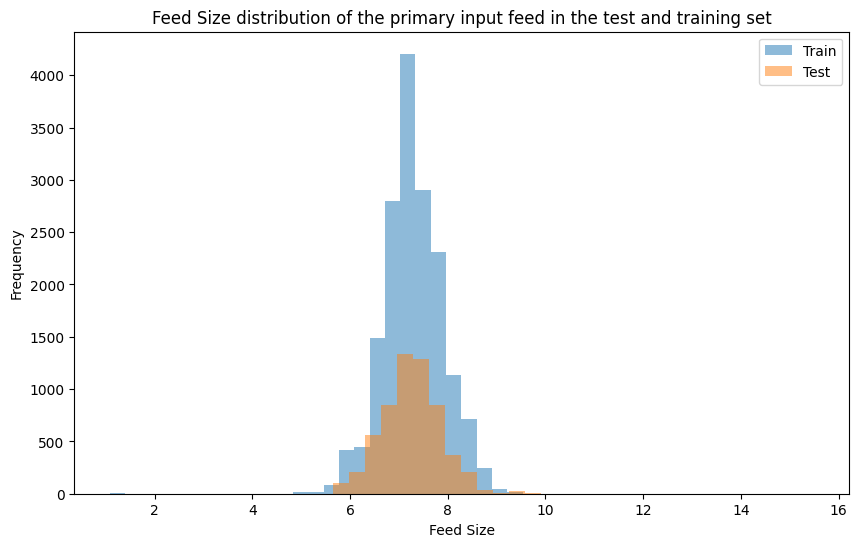

In [33]:
#plotting size distribution of primary-cleaner input feed size
plt.figure(figsize=(10,6))
plt.hist(gold_recovery_train['primary_cleaner.input.feed_size'],bins=30,alpha=0.5,label='Train')
plt.hist(gold_recovery_test['primary_cleaner.input.feed_size'],bins=30,alpha=0.5,label='Test')
plt.title("Feed Size distribution of the primary input feed in the test and training set")
plt.xlabel("Feed Size")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The feed particle size distributions mostly overlap for both the rougher and primary cleaner input. There are more samples with the same size in the training set which is to be expected since the dataset has more samples. We do not expect any issues with the model evaluation.

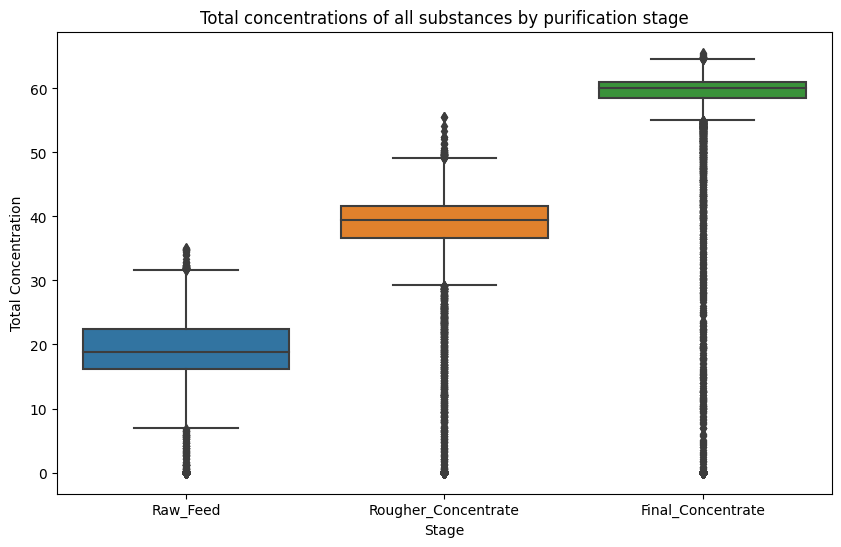

In [34]:
gold_recovery_train['Raw_Feed'] = gold_recovery_train['rougher.input.feed_ag'] + gold_recovery_train['rougher.input.feed_pb'] + gold_recovery_train['rougher.input.feed_au']
gold_recovery_train['Rougher_Concentrate'] = gold_recovery_train['rougher.output.concentrate_ag'] + gold_recovery_train['rougher.output.concentrate_pb'] + gold_recovery_train['rougher.output.concentrate_au']
gold_recovery_train['Final_Concentrate'] = gold_recovery_train['final.output.concentrate_ag'] + gold_recovery_train['final.output.concentrate_pb'] + + gold_recovery_train['final.output.concentrate_au']
plt.figure(figsize=(10,6))
sns.boxplot(data=gold_recovery_train[['Raw_Feed','Rougher_Concentrate','Final_Concentrate']])
plt.title("Total concentrations of all substances by purification stage")
plt.xlabel("Stage")
plt.ylabel("Total Concentration")
plt.show()

We see that at every stage there are total concentrations that sum to less than 0 which is not logical. There are no values that sum to greater than 100%, which is good. We are assuming that consistent with the way data is recorded for gold and other mineral purifications, the data is expresses as percentages. There are values where the total concentration of metals at a lower stage is higher than the lower limits for the next stage of purification. This is likely because data was incorrectly recorded or because the purification process failed due to some technical issue. These values can be removed from the training set to avoid faulty results.

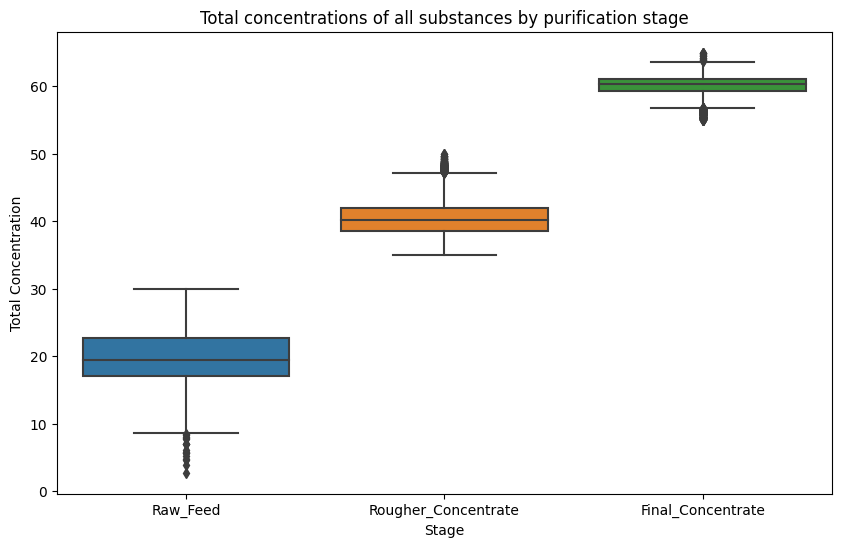

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9706 entries, 0 to 16859
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               9706 non-null   float64
 1   primary_cleaner.input.depressant            9706 non-null   float64
 2   primary_cleaner.input.feed_size             9706 non-null   float64
 3   primary_cleaner.input.xanthate              9706 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      9706 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    9706 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      9706 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    9706 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      9706 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    9706 non-null   float64
 10  primary_cle

In [35]:
#removing anomalies which are defined as total values below 0, above 100 and anything where an intermediate stage is above the upper bounds of the next stage
#we are setting a stringent limit to be sure there is no overlap between stages
gold_recovery_train = gold_recovery_train[(gold_recovery_train['Raw_Feed'] >= 0.1) & (gold_recovery_train['Raw_Feed'] <= 30)]
gold_recovery_train = gold_recovery_train[(gold_recovery_train['Rougher_Concentrate'] >= 35) & (gold_recovery_train['Rougher_Concentrate'] <= 50)]
gold_recovery_train = gold_recovery_train[(gold_recovery_train['Final_Concentrate'] >= 55)]
#replotting the boxplot to visualize results of anomaly removal
plt.figure(figsize=(10,6))
sns.boxplot(data=gold_recovery_train[['Raw_Feed','Rougher_Concentrate','Final_Concentrate']])
plt.title("Total concentrations of all substances by purification stage")
plt.xlabel("Stage")
plt.ylabel("Total Concentration")
plt.show()
#resetting the features and target sets to reflect changes
gold_recovery_train_nomiss = gold_recovery_train.dropna()
gold_recovery_features = gold_recovery_train_nomiss[common_cols].copy()
gold_recovery_features.drop('date',axis=1,inplace=True)
gold_recovery_features.info()
print(gold_recovery_features.isna().sum())
gold_recovery_target = gold_recovery_train_nomiss[['rougher.output.recovery','final.output.recovery']].copy()
print(gold_recovery_target.isna().sum())

We regenerate the features and target set to reflect the removal of the anomalies. We now have a training set with close to 10000 rows which we can use to train our models.

# Building the Model

We will now proceed to build the model that allows us to predict the target recovery and that minimizes the symmetric mean absolute percentage error

In [36]:
#scaling the features since they cover a wide range
scaler = StandardScaler()
scaler.fit(gold_recovery_features)
gold_recovery_features_scaled = scaler.transform(gold_recovery_features)
#defining a function for final sMAPE
def f_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    eps = 1e-8  # to avoid division by zero min for denominator
    # assume y_true and y_pred are 2D NumPy arrays with two columns
    diff1 = np.abs(y_pred[:, 0] - y_true[:, 0])
    denom1 = (np.abs(y_true[:, 0]) + np.abs(y_pred[:, 0])) / 2
    smape1 = np.mean(diff1 / np.clip(denom1, eps, None)) * 100 #rougher smape
    diff2 = np.abs(y_pred[:, 1] - y_true[:, 1])
    denom2 = (np.abs(y_true[:, 1]) + np.abs(y_pred[:, 1])) / 2
    smape2 = np.mean(diff2 / np.clip(denom2, eps, None)) * 100 #final smape
    fsmape = (0.25 * smape1) + (0.75 * smape2)
    return fsmape
f_smape_scorer = make_scorer(f_smape, greater_is_better=False)
model1 = MultiOutputRegressor(LinearRegression())
model2 = MultiOutputRegressor(DecisionTreeRegressor(random_state=54321))
model3 = MultiOutputRegressor(RandomForestRegressor(random_state=54321, n_estimators=100))
score1 = cross_val_score(model1, gold_recovery_features_scaled, gold_recovery_target, scoring=f_smape_scorer, cv=5)
score2 = cross_val_score(model2, gold_recovery_features_scaled, gold_recovery_target, scoring=f_smape_scorer, cv=5)
score3 = cross_val_score(model3, gold_recovery_features_scaled, gold_recovery_target, scoring=f_smape_scorer, cv=5)
print("Mean sMAPE LinearRegression:", -np.mean(score1))
print("Mean sMAPE DecisionTreeRegressor:", -np.mean(score2))
print("Mean sMAPE RandomForestRegressor:", -np.mean(score3))

Mean sMAPE LinearRegression: 8.639537885311885
Mean sMAPE DecisionTreeRegressor: 12.268885992323826
Mean sMAPE RandomForestRegressor: 8.514806339629974


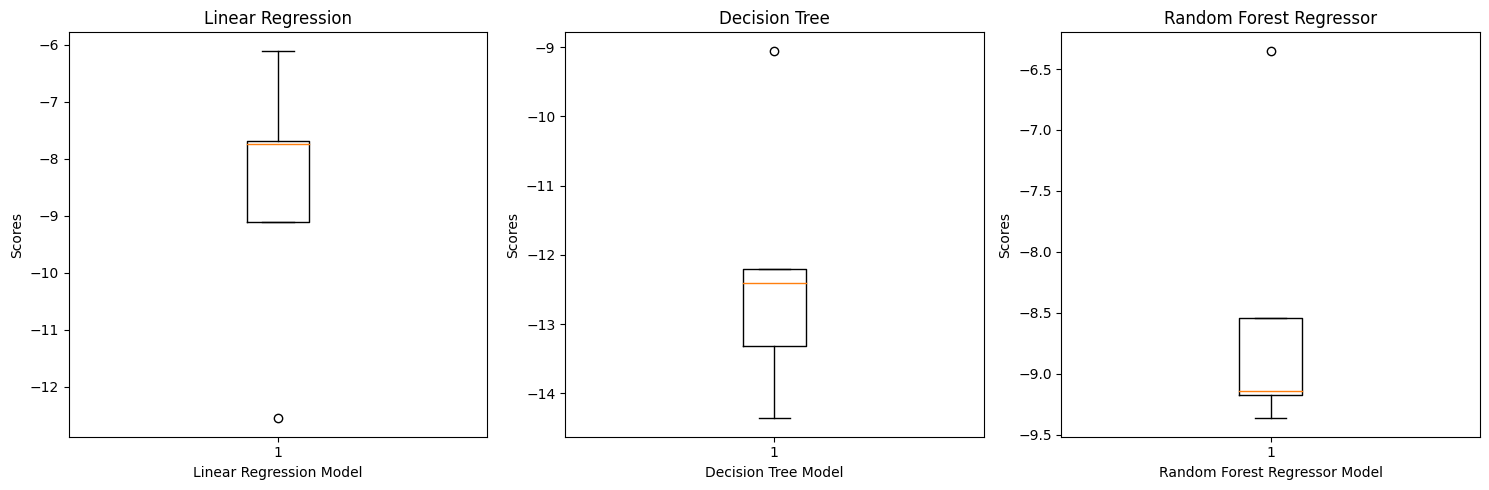

The mean score for the Linear Regressor is -8.64 and median is -7.75
The mean score for the Decision Tree is -12.27 and median is -12.40
The mean score for the Random Forest Regressor is -8.51 and median is -9.14


In [37]:
# Creates subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# Plots Boxplot for Linear Regression
axs[0].boxplot(score1)
axs[0].set_title('Linear Regression')
axs[0].set_xlabel('Linear Regression Model')
axs[0].set_ylabel('Scores')
# Plots Boxplot for Decision Tree
axs[1].boxplot(score2)
axs[1].set_title('Decision Tree')
axs[1].set_xlabel('Decision Tree Model')
axs[1].set_ylabel('Scores')
# Plots Boxplot for Random Forest Regressor
axs[2].boxplot(score3)
axs[2].set_title('Random Forest Regressor')
axs[2].set_xlabel('Random Forest Regressor Model')
axs[2].set_ylabel('Scores')
# Adjusts layout
plt.tight_layout()
plt.show()
print(f"The mean score for the Linear Regressor is {np.mean(score1):0.2f} and median is {np.median(score1):0.2f}")
print(f"The mean score for the Decision Tree is {np.mean(score2):0.2f} and median is {np.median(score2):0.2f}")
print(f"The mean score for the Random Forest Regressor is {np.mean(score3):0.2f} and median is {np.median(score3):0.2f}")

It appears that the Linear Regression Model is ideal for our data. Even thought the mean of the scores is lower for random forest by a sliver, the median and the shift os the scores indicates the sMAPE is lowest for linear regressor (approaching 0). Further training will be done using this model.
There are no hyper parameters to tune in linear regression models. We can just re-train the model on the complete training set and then calculate s-MAPE for the test set.

In [38]:
#splitting the training set for final training of the model
df_train_features, df_valid_features, df_train_target,df_valid_target = train_test_split(gold_recovery_features_scaled,gold_recovery_target, test_size=0.25, random_state=54321)
#scaling the test set
gold_recovery_test.drop('date',axis=1,inplace=True)
gold_recovery_test.dropna(inplace=True)
gold_recovery_test_scaled = scaler.transform(gold_recovery_test)
#model training
best_model = MultiOutputRegressor(LinearRegression())
best_model.fit(df_train_features,df_train_target)
best_pred = best_model.predict(df_valid_features)
best_score = f_smape(df_valid_target, best_pred)
print(f"sMAPE for the linear regression model after training is: {best_score:0.2f}")

sMAPE for the linear regression model after training is: 5.85


In [39]:
gold_reco_test = pd.read_csv('/datasets/gold_recovery_test.csv')
# merging test and full using date column
merge_key = 'date'
common_cols = set(gold_reco_test.columns).intersection(gold_recovery_full.columns) - {merge_key}
# restricting to rows in test
smaller_df = gold_reco_test
larger_df = gold_recovery_full
smaller_df['date'] = pd.to_datetime(smaller_df['date'])
#Merge using an inner join to keep only rows from the smaller dataframe
merged = pd.merge(smaller_df, larger_df, on=merge_key, how='left', suffixes=('_small', '_large'))
#Drop overlapping columns from the larger dataframe
for col in common_cols:
    merged.drop(columns=[f"{col}_large"], inplace=True)
#Rename the remaining columns
for col in common_cols:
    merged.rename(columns={f"{col}_small": col}, inplace=True)
gold_recovery_test_target = merged[['rougher.output.recovery','final.output.recovery']].copy()
gold_recovery_test_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rougher.output.recovery  5310 non-null   float64
 1   final.output.recovery    5414 non-null   float64
dtypes: float64(2)
memory usage: 137.2 KB


sMAPE for the linear regression model for the test set is: 10.47


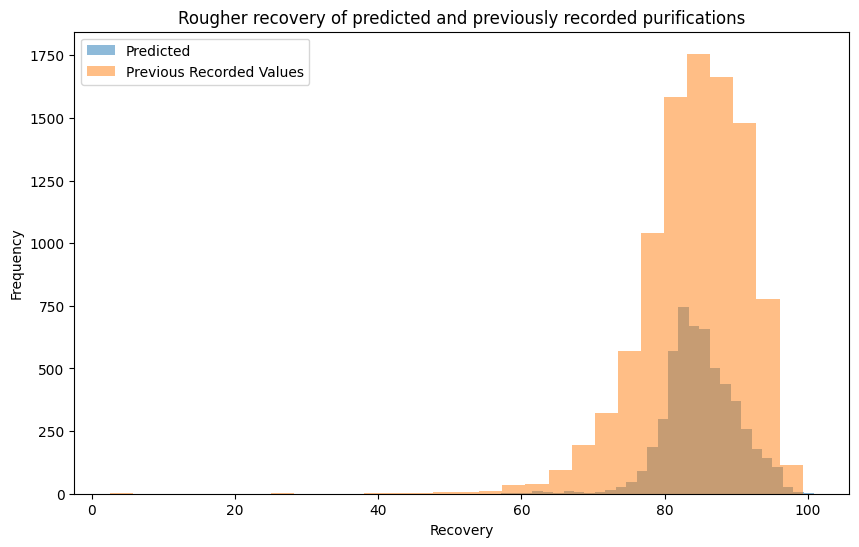

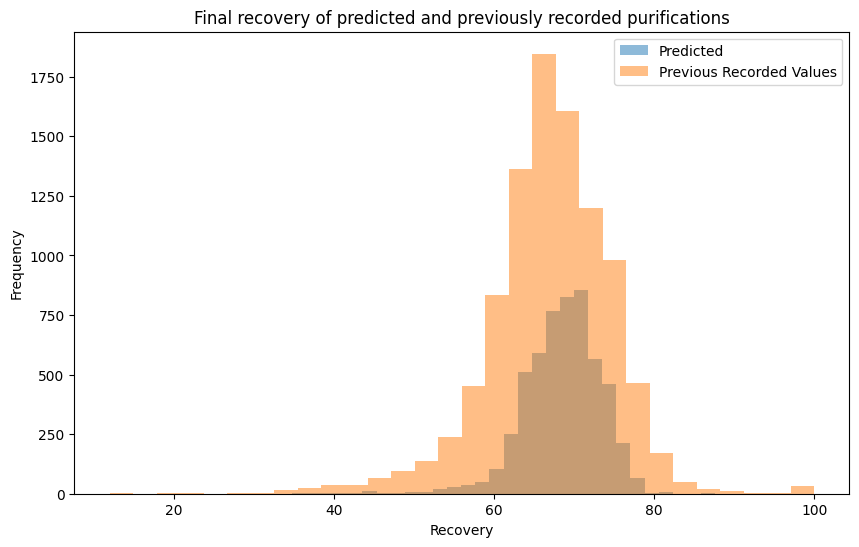

In [40]:
#predicting 
test_pred = best_model.predict(gold_recovery_test_scaled)
#filtering values missing in the true set
def filter_na_rows(y_true, y_pred):
    # Ensure both are DataFrames and reset index to align them
    y_true_df = pd.DataFrame(y_true, columns=['rougher.output.recovery', 'final.output.recovery']).reset_index(drop=True)
    y_pred_df = pd.DataFrame(y_pred, columns=['rougher.output.recovery', 'final.output.recovery']).reset_index(drop=True)
    min_len = min(len(y_true_df), len(y_pred_df)) #choosing the length of the dataframe with less rows as the final length
    y_true_df = y_true_df.iloc[:min_len] #limiting both dataframes to this length
    y_pred_df = y_pred_df.iloc[:min_len]
    valid_mask = ~y_true_df.isna().any(axis=1) #select only rows where there are no missing values for the true values in any column
    y_true_clean = y_true_df.loc[valid_mask].to_numpy() #filter both using the mask and return a numpy array for the fsMAPE function
    y_pred_clean = y_pred_df.loc[valid_mask].to_numpy()
    return y_true_clean, y_pred_clean
test_true,test_predicted = filter_na_rows(gold_recovery_test_target,test_pred)
test_score = f_smape(test_true,test_predicted)
print(f"sMAPE for the linear regression model for the test set is: {test_score:0.2f}")
#plotting frequency distribution of rougher recovery predictions against known rougher recovery
test_predicted_df = pd.DataFrame(test_pred, columns=['rougher.output.recovery', 'final.output.recovery']).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.hist(test_predicted_df['rougher.output.recovery'],bins=30,alpha=0.5,label='Predicted')
plt.hist(gold_recovery_target['rougher.output.recovery'],bins=30,alpha=0.5,label='Previous Recorded Values')
plt.title("Rougher recovery of predicted and previously recorded purifications")
plt.xlabel("Recovery")
plt.ylabel("Frequency")
plt.legend()
plt.show()
#plotting frequency distribution of final recovery predictions against known final recovery
plt.figure(figsize=(10,6))
plt.hist(test_predicted_df['final.output.recovery'],bins=30,alpha=0.5,label='Predicted')
plt.hist(gold_recovery_target['final.output.recovery'],bins=30,alpha=0.5,label='Previous Recorded Values')
plt.title("Final recovery of predicted and previously recorded purifications")
plt.xlabel("Recovery")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The values predicted for the test data set are largely within the range recorded in previous purifications. The sMAPE value is higher than that for the training set but a lot of the recorded values for recovery were missing for the test set and considering that all the recovery values, both for rougher recovery and final recovery are within the expected range, the model appears to be able to predict the recovery of gold reasonably well.

# Conclusion:
In this project we built a model to predict the recovery of gold in the rougher concentrate as well as the final purified output for the company, Zyfra.
We studied the purification process to understand the parameters of interest. We examined the available data for data types that were inconsistent, missing values and duplications.
We attempted to fill in the missing values in the provided training set using the most complete data set (gold_recovery_full). However, we noticed were missing in the larger dataset as well.

Considering the large number of likely interdependent features, the decision was made that we would proceed by dropping rows with missing values in the training set.
In the test set we noticed that the missing columns were mostly output columns which made sense since there was a high possibility of leakage which could affect model performance.
We dropped the corresponding rows in the training set and proceeded to analyze the data sets. We determined that the recovery had been calculated correctly but the final recovery was calculated using the ore as a starting point and not rougher output as suggested in the project description. Since this seemed to be a more appropriate starting point to calculate the recovery from purification, we left these values as is.

We saw that there was a reduction in contaminants like silver and an increase in the gold concentration as the purification progressed but no appreciable change in lead concentration was observed. This appears to be a contaminant that is difficult to get rid of and future optimization could be focused on further reducing the concentration of lead.
The particle size for the rougher feed and input feed were largely consistent between the training and the test set and we had some confidence that the model evaluation would proceed without impediment on account of variations in this parameter.

We analyzed the total concentration of susbtances at different purification stages and removed anomalies from the training set that lead to total percentages above 100, below 0 or values that lead to total percentages higher at lower stages of purification compared to more advanced stages. Stringent parameters were used to separate the stages since we believed the model would perform better if there were less confounding values.

We then wrote a function to calculate final sMAPE according to the formula provided. We trained three models with cross validation on the training set (linear regression, decision tree and random forest). The model was optimized for lowest sMAPE values and judging by this parameter the best model was linear regression. We split the training set again and trained the model a final time, calculated the sMAPE value for the validation set which was quite low (around 5). Predictions were made for the test set and after filling in missing values from the full set, we calculated the sMAPE value for the test set as well. this value turned out to be higher. However, the predictions for the test set were well within the expected range of recovery rates for both rougher recovery and final recovery and combined with the earlier sMAPE value distributions and performance on the validation set, the model appears to predict the recovery of gold quite well.